In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow import keras
from tensorflow.keras import layers
import pickle
import os
import shutil
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.preprocessing import image
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras import models
from keras import layers
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
import matplotlib.pyplot as plt


from keras.applications import VGG16

In [2]:
tumordata = "tumordata2/training"
#data_from_kaggle_test = "data-from-kaggle/test1"
#data_dirname = "tumordetection"

In [3]:
def make_dataset(subset_name, start_idx, end_idx):
    for category in { "tr-no", "tumor" }:
        # data_dirname/subset_name/categoroy 
        dir = f"{data_dirname}/{subset_name}/{category}"
        # print(dir)
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_idx, end_idx)]
        # print(fnames)
        for fname in fnames: 
                shutil.copyfile(src=f"{tumordata}/{fname}", dst=f"{dir}/{fname}") 


In [4]:
base_dir = "tumordata2"
train_dir = os.path.join(base_dir, 'Training')
validation_dir = os.path.join(base_dir, 'Validation')
test_dir = os.path.join(base_dir, 'Testing')
datagen = ImageDataGenerator(rescale=1./255)

In [5]:
conv_base = VGG16(weights='imagenet',
        include_top=False,
        input_shape=(180, 180, 3))

In [6]:
batch_size = 20

In [7]:
def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 5, 5, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
    directory,
    target_size=(256, 256),
    batch_size= batch_size,
    class_mode='binary')
    i=0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels

In [8]:
#train_features, train_labels = extract_features(train_dir, 10)
#validation_features, validation_labels = extract_features(validation_dir, 10)
#test_features, test_labels = extract_features(test_dir, 10)


#train_features = np.reshape(train_features, (10, 5*5* 512))
#validation_features = np.reshape(validation_features, (10, 5*5* 512))
#test_features = np.reshape(test_features, (10, 5*5* 512))


In [9]:
def build_model():
        conv_base = VGG16(weights='imagenet',
                include_top=False,
                input_shape=(256, 256, 3))
        conv_base.trainable = False
        model = models.Sequential()
        model.add(conv_base,)
        model.add(layers.Flatten())
        model.add(layers.Dense(256, activation='relu'))
        model.add(layers.Dropout(0.2))
        model.add(layers.Dense(1, activation='sigmoid'))

    #model = keras.Model(inputs=input, outputs=outputs)    
        return model


In [10]:
mode = build_model()

In [11]:
mode.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 256)               8388864   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 23103809 (88.13 MB)
Trainable params: 8389121 (32.00 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


In [12]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers
from tensorflow.keras.models import load_model

def fit20(model):
    train_dir = os.path.join(base_dir, 'Training')
    batch_size = 32  # You can adjust this based on your requirements

    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest',
        #validation_split=0.2  # 20% of the training data will be used for validation
    )
    batch_size = 20

    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(256, 256),
        batch_size=batch_size,
        class_mode='binary',
        #subset='training'  # Use the training subset of the data
    )

    validation_generator = train_datagen.flow_from_directory(
        validation_dir,
        target_size=(256, 256),
        batch_size=batch_size,
        class_mode='binary',
        #subset='validation'  # Use the validation subset of the data
    )

    model.compile(
        optimizer='adam',  # Use Adam optimizer
        loss='binary_crossentropy',
        metrics=['acc']
    )
    #callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
    

    history = model.fit(
        train_generator,
        steps_per_epoch=100,
        epochs=100,
        validation_data=validation_generator,
        validation_steps=50,
        #callbacks=[callback]
    )

    model.save("Omar_Rabbah_binary")

    # Plotting the training and validation metrics
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.figure()

    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()



Found 5418 images belonging to 2 classes.
Found 1008 images belonging to 2 classes.
Epoch 1/3
1/1 [==============================] - 36s 36s/step - loss: 0.6915 - acc: 0.6500 - val_loss: 8.3673 - val_acc: 0.4000
Epoch 2/3
1/1 [==============================] - 33s 33s/step - loss: 12.8809 - acc: 0.1000 - val_loss: 0.4702 - val_acc: 0.9500
Epoch 3/3
1/1 [==============================] - 33s 33s/step - loss: 0.8524 - acc: 0.9000 - val_loss: 4.0474 - val_acc: 0.7500
INFO:tensorflow:Assets written to: Omar_Rabbah_binary\assets


INFO:tensorflow:Assets written to: Omar_Rabbah_binary\assets


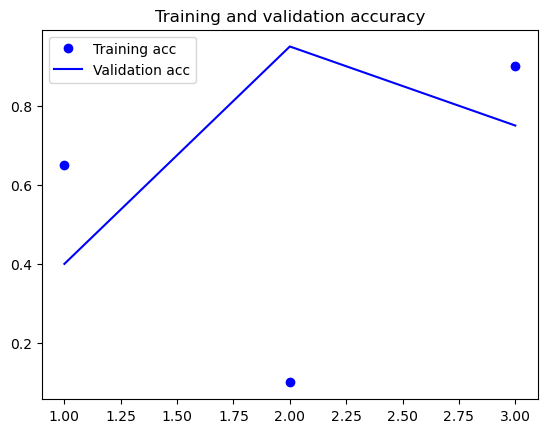

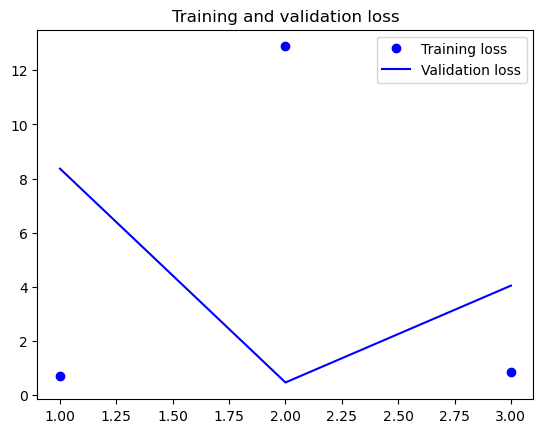

In [13]:
fit20(mode)

In [14]:

import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers
from tensorflow.keras.models import load_model

import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow import keras
from tensorflow.keras import layers
import pickle
import os
import shutil
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.preprocessing import image
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras import models
from keras import layers
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
import matplotlib.pyplot as plt



base_dir = "tumordata2"
train_dir = os.path.join(base_dir, 'Training')
validation_dir = os.path.join(base_dir, 'Validation')
test_dir = os.path.join(base_dir, 'Testing')
datagen = ImageDataGenerator(rescale=1./255)


train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    #validation_split=0.2  # 20% of the training data will be used for validation
)
batch_size = 20

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(256, 256),
    batch_size=batch_size,
    class_mode='binary',
    #subset='training'  # Use the training subset of the data
)

validation_generator = train_datagen.flow_from_directory(
    validation_dir,
    target_size=(256, 256),
    batch_size=batch_size,
    class_mode='binary',
    #subset='validation'  # Use the validation subset of the data
)

Found 5418 images belonging to 2 classes.
Found 1008 images belonging to 2 classes.
